# 1-Deviation Confidence Interval as Convergence Criteria for Stochastic Gradient Ascent
## Addressable Thoughts

In [1]:
using Distributions
using LinearAlgebra
using Plots
using Sobol
using Random

In [6]:
include("../testfns.jl")
include("../rollout.jl")

distributed_rollout_solver (generic function with 1 method)

## Problem Setup
We have two potential approaches for solving $\alpha_h(x)$. We can either use some variant of Monte Carlo simulation or take a Sample Average Approximation and use a deterministic optimization algorithm. We'll begin by investigating the first option, namely, getting stochastic estimates of $\nabla \alpha_h(x)$ and using stochastic gradient ascent to optimize the function.

We begin by considering a problem in 1D.

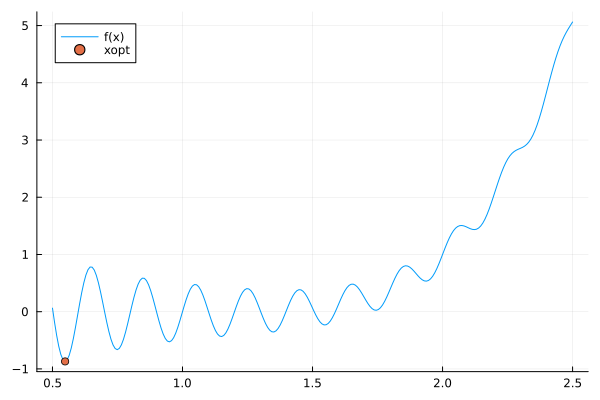

In [7]:
testfn = TestGramacyLee()
tplot(testfn)

In [92]:
Random.seed!(2842)

# Paramaters
MC_SAMPLES = 100
NUMBER_OF_STARTS = 8
NUMBER_OF_TRIALS = 10
trial = 1
HORIZON = 1
BUDGET = 15
BATCH_SIZE = 16

# Gaussian process hyperparameters
θ, σn2 = [1.], 1e-6
ψ = kernel_matern52(θ)

lbs, ubs = testfn.bounds[:,1], testfn.bounds[:,2]

# Generate low discrepancy sequence
lds_rns = gen_low_discrepancy_sequence(MC_SAMPLES, testfn.dim, HORIZON + 1)

# Allocate initial guesses for optimizer
initial_guesses = generate_initial_guesses(NUMBER_OF_STARTS, lbs, ubs)

# Allocate all initial samples
initial_samples = randsample(NUMBER_OF_TRIALS, testfn.dim, lbs, ubs)

# Initialize the trajectory parameters
tp = TrajectoryParameters(
    initial_samples[:, end], # Will be overriden later
    HORIZON,
    MC_SAMPLES,
    lds_rns,
    lbs,
    ubs,
)

# Initialize batch of points to evaluate the rollout acquisition function
batch = generate_batch(BATCH_SIZE, lbs=tp.lbs, ubs=tp.ubs)

# Initialize containers for inner optimization solves
candidate_locations = SharedMatrix{Float64}(testfn.dim, NUMBER_OF_STARTS)
candidate_values = SharedArray{Float64}(NUMBER_OF_STARTS)

# Setup surrogate
Xinit = initial_samples[:, trial:trial]
yinit = testfn.f.(eachcol(Xinit))
sur = fit_surrogate(ψ, Xinit, yinit; σn2=σn2);
fsur = fit_fsurrogate(sur, 0);

## Densely Evaluate the Rollout Acquisition Function
Since we're densely evaluating the rollout acquisition function on the real line, it'd behoove use to keep $h \leq 1$.

In [95]:
domain = first(lbs):.01:first(ubs)
dense_evaluation = zeros(length(domain), 2)


for (j, x) in enumerate(domain)
    print("|")
    # Update the trajectory initial starting point
    tp.x0 = [x]
    # Simulate the trajectory for each point on the real line
    μx, ∇μx, stderr_μx, stderr_∇μx = simulate_trajectory(
        sur, tp, initial_guesses;
        candidate_locations=candidate_locations, candidate_values=candidate_values, variance_reduction=false
    )
    dense_evaluation[j, 1] = μx
    dense_evaluation[j, 2] = stderr_μx
end

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

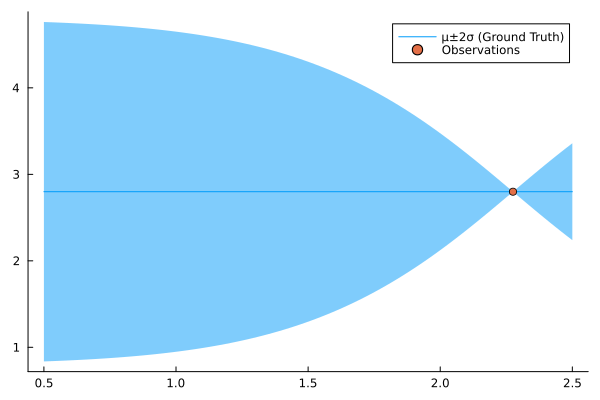

In [78]:
plot1D(sur; xmin=first(lbs), xmax=first(ubs))

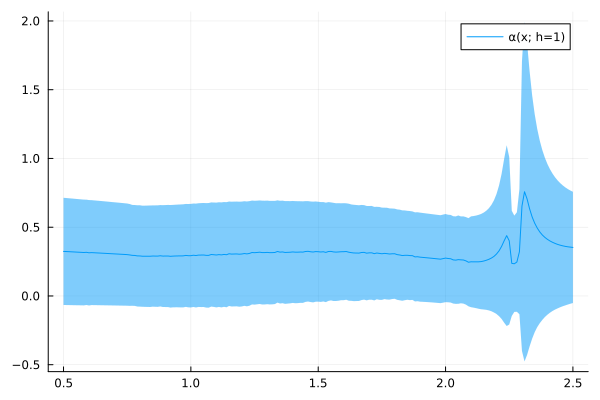

In [104]:
slice = 1:length(domain)
plot(
    domain[slice],
    dense_evaluation[slice, 1],
    label="α(x; h=$(HORIZON))",
    ribbons=dense_evaluation[slice, 2],
)

## On Interpreting the Meaning of 1-Deviation Confidence Interval
I suspect the 1-deviation confidence interval and looking at the confidence interval constructed for our gradient estimates. Given some fixed number of SGA iterations $N_s$, we have the following sequence:

$$
\left(\nabla\hat{\alpha}_h(x)\right)_{N_s} \equiv \left(\nabla\hat{\alpha}_h(x_1), \dots, \nabla\hat{\alpha}_h(x_{N_s})\right)
$$

However, since $\nabla\hat{\alpha}_h(x_k)$ is a stochastic gradient, we estimate it via Monte Carlo integration for some $N_{mc}$ samples, i.e.:

$$
\nabla\hat{\alpha}_h(x_k) \approx \frac{1}{N}\sum_{i=1}^N \left(-\nabla\left[\bigl(t^i(x_{k})\bigr)^-\right]\right)^+
$$

If we cache each iteration of the MC integration procedure, we can estimate some sample statistics and use this to get a rough estimate on the confidence interval associated with each gradient estimate. The idea is to then use this for the convergence criteria.

In [40]:
# μ: sample mean
# s: standard error
# n: number of samples
function confidence_interval(μ, z, s, n)
    common = z * (s / sqrt(n))
    return (μ - common, μ + common)
end

CI = confidence_interval

function one_deviation_CI(μ, s, n)
    return CI(μ, 1., s, n)
end

one_deviation_CI (generic function with 1 method)

In [63]:
μx, ∇μx, stderr_μx, stderr_∇μx = simulate_trajectory(
    sur, tp, initial_guesses;
    candidate_locations=candidate_locations, candidate_values=candidate_values, variance_reduction=false
)

(0.24197403513149449, [-0.01307503019993566], 0.35109531990056725, 0.8027621047667717)

In [67]:
# one_deviation_CI(norm(∇μx), stderr_∇μx, tp.mc_iters)
CI(norm(∇μx), .05, stderr_∇μx, tp.mc_iters)

(0.009061219676101802, 0.017088840723769518)